In [1]:
import pandas as pd
import numpy as np

file_path = './dataset/En_In.xls'

# Attempt to load with appropriate rows skipped based on the observed layout
df = pd.read_excel(file_path, skiprows=17, engine='xlrd')  # skip to row 18, where data might start

# Drop the first two columns if they are irrelevant, as instructed
df = df.iloc[:, 2:]

# Rename columns to specified labels
df.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']

In [2]:
# Convert 'Energy Supply' from Petajoules to Gigajoules, where 1 Petajoule = 1,000,000 Gigajoules
df['Energy Supply'] = pd.to_numeric(df['Energy Supply'], errors='coerce') * 1_000_000

# Replace '...' with np.nan and ensure the column is float to avoid warnings
df['Energy Supply per Capita'] = pd.to_numeric(df['Energy Supply per Capita'], errors='coerce')

In [10]:
# Renaming specific countries as specified in the task
df['Country'] = df['Country'].replace({
    "Republic of Korea": "South Korea",
    r'\bUnited States of America\b': "United States",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "China, Hong Kong Special Administrative Region": "Hong Kong",
    "Venezuela, RB": "Venezuela",
    "Democratic People's Republic of Korea": "North Korea"
})

In [11]:
import re

# Remove numbers and text within parentheses from country names
df['Country'] = df['Country'].replace({
    r'\d+': '',  # Remove any digits
    r'\s*\(.*\)': ''  # Remove any text within parentheses
}, regex=True)


In [12]:
filtered_df = df[df['Country'].isin(['American Samoa', 'South Korea', 'Bolivia'])]
filtered_df

,Country,Energy Supply,Energy Supply per Capita,% Renewable
3,American Samoa,NaN,NaN,0.641026
24,Bolivia,3.360000e+08,32.0,31.477120
164,South Korea,1.100700e+10,221.0,2.279353
214,United Kingdom,7.920000e+09,124.0,10.600470


In [13]:
# Assuming 'gpd.csv' is available in the environment
file_path_gdp = './dataset/gpd.csv'

# Load the CSV file without header row
gdp_df = pd.read_csv(file_path_gdp, header=4)  # Skipping the first four rows to reach data

# Rename specific countries in the 'Country Name' column
gdp_df['Country Name'] = gdp_df['Country Name'].replace({
    "Korea, Rep.": "South Korea",
    "Iran, Islamic Rep.": "Iran",
    "Hong Kong SAR, China": "Hong Kong",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Korea, Dem. People’s Rep.": "North Korea"
})

gdp_df.head(1)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.467704e+09,NaN,NaN,NaN,NaN,NaN


In [14]:
file_path_scimagojr = './dataset/scimagojr.xlsx'

# Load the Excel file into a DataFrame
scimagojr_df = pd.read_excel(file_path_scimagojr)


In [15]:
# Apply renaming with regex to remove any potential trailing spaces or characters
df['Country'] = df['Country'].replace({
    r'\bUnited States of America\b': 'United States'  # Explicit regex to match whole phrase
}, regex=True)

# Verify if the renaming was successful by checking if "United States" is now in the dataset
df[df['Country'] == "United States"]


,Country,Energy Supply,Energy Supply per Capita,% Renewable
216,United States,9.083800e+10,286.0,11.57098


In [16]:
# Step 1: Filter the GDP dataset for the last 10 years (2006-2015)
gdp_recent = gdp_df[['Country Name'] + [str(year) for year in range(2006, 2016)]]

# Step 2: Filter Scimagojr dataset to include only the top 15 countries by rank (Rank 1 to 15)
scimagojr_top15 = scimagojr_df[scimagojr_df['Rank'] <= 15]

# Step 3: Merge Energy and Scimagojr datasets on 'Country'
energy_scimagojr_merged = pd.merge(df, scimagojr_top15, how='inner', left_on='Country', right_on='Country')

# Step 4: Merge the result with the GDP dataset using 'Country Name' from gdp_recent and 'Country' from merged DataFrame
final_merged_df = pd.merge(energy_scimagojr_merged, gdp_recent, how='inner', left_on='Country', right_on='Country Name')

# Drop the redundant 'Country Name' column after merging
final_merged_df.drop('Country Name', axis=1, inplace=True)

# Step 5: Set the index to 'Country' and reorder columns as specified
final_merged_df.set_index('Country', inplace=True)
final_columns_order = ['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
                       'Citations per document', 'H index', 'Energy Supply', 'Energy Supply per Capita', 
                       '% Renewable'] + [str(year) for year in range(2006, 2016)]
final_merged_df = final_merged_df[final_columns_order]

# Display the sorted DataFrame to confirm inclusion and ordering
final_merged_df_sorted = final_merged_df.sort_values(by='Rank')
final_merged_df_sorted.head(3)


,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.70,138,1.271910e+11,93.0,19.75491,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12
United States,2,96661,94747,792274,265436,8.20,230,9.083800e+10,286.0,11.57098,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13
Japan,3,30504,30287,223024,61554,7.31,134,1.898400e+10,149.0,10.23282,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12


In [17]:
# Defining a function to calculate the average GDP for each country over the last 10 years (2006-2015)

def average_gdp(df):
    # Calculate the mean GDP across the years 2006 to 2015 for each country
    gdp_columns = [str(year) for year in range(2006, 2016)]
    avg_gdp = df[gdp_columns].mean(axis=1)
    
    # Sort the result in descending order and return as a Series
    return avg_gdp.sort_values(ascending=False)

# Applying the function to the final_merged_df and displaying the result
average_gdp_series = average_gdp(final_merged_df)
average_gdp_series


Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
dtype: float64

In [18]:
# Define a function to calculate the change in GDP over the last 10 years
# for the country with the 5th highest average GDP

def gdp_change_for_5th_highest_avg_gdp(df):
    # Select the GDP columns for the last 10 years
    gdp_columns = [str(year) for year in range(2006, 2016)]
    
    # Calculate the average GDP over these years for each country
    avg_gdp = df[gdp_columns].mean(axis=1)
    
    # Sort the countries by average GDP in descending order and get the 5th highest
    country_with_5th_highest_avg_gdp = avg_gdp.sort_values(ascending=False).index[4]
    
    # Calculate the GDP change over the last 10 years for this country
    gdp_2006 = df.loc[country_with_5th_highest_avg_gdp, '2006']
    gdp_2015 = df.loc[country_with_5th_highest_avg_gdp, '2015']
    gdp_change = gdp_2015 - gdp_2006
    
    # Return a tuple with the country name and the GDP change
    return (country_with_5th_highest_avg_gdp, gdp_change)

# Apply the function to the sorted final DataFrame and display the result
gdp_change_for_5th_highest_avg_gdp(final_merged_df_sorted)


('France', np.float64(153345695364.24023))

In [19]:
# Define a function to find the country with the maximum percentage of renewable energy
# and the percentage value itself

def country_with_max_renewable(df):
    # Find the country with the maximum % Renewable
    max_renewable_country = df['% Renewable'].idxmax()
    max_renewable_value = df['% Renewable'].max()
    
    # Return a tuple with the country name and the renewable percentage
    return (max_renewable_country, max_renewable_value)

# Apply the function to the final DataFrame and display the result
country_with_max_renewable(final_merged_df_sorted)


('Brazil', np.float64(69.64803))

In [20]:
# Define a function to estimate the population based on Energy Supply and Energy Supply per Capita
# and find the country that ranks 6th by this population estimate

def sixth_largest_population(df):
    # Create a new column for the estimated population
    df['Estimated Population'] = df['Energy Supply'] / df['Energy Supply per Capita']
    
    # Sort by the estimated population in descending order
    sorted_population = df['Estimated Population'].sort_values(ascending=False)
    
    # Find the 6th largest population estimate
    sixth_largest_country = sorted_population.index[5]
    sixth_largest_population_value = sorted_population.iloc[5]
    
    # Return a tuple with the country name and the population estimate
    return (sixth_largest_country, sixth_largest_population_value)

# Apply the function to the final DataFrame
sixth_largest_population(final_merged_df_sorted)


('Japan', np.float64(127409395.97315437))

In [21]:
# Step 1: Create a new column for cited documents per person
final_merged_df_sorted['Cited Documents per Person'] = final_merged_df_sorted['Citations'] / final_merged_df_sorted['Estimated Population']

# Step 2: Calculate the Pearson correlation between 'Cited Documents per Person' and 'Energy Supply per Capita'
correlation_value = final_merged_df_sorted['Cited Documents per Person'].corr(final_merged_df_sorted['Energy Supply per Capita'])

# Display the correlation value
correlation_value

np.float64(0.6668248468590926)

In [22]:
def create_renewable_indicator(df):
    renewable_median = df['% Renewable'].median()
    
    df['Renewable Indicator'] = (df['% Renewable'] >= renewable_median).astype(int)
    
    return df.sort_values('Rank')['Renewable Indicator']

result_series = create_renewable_indicator(final_merged_df)
result_series

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: Renewable Indicator, dtype: int64

In [23]:
final_merged_df['Estimated Population'] = final_merged_df['Energy Supply'] / final_merged_df['Energy Supply per Capita']

ContinentDict = {
    'China': 'Asia',
    'United States': 'North America',
    'Japan': 'Asia',
    'United Kingdom': 'Europe',
    'Russian Federation': 'Europe',
    'Canada': 'North America',
    'Germany': 'Europe',
    'India': 'Asia',
    'France': 'Europe',
    'South Korea': 'Asia',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'Iran': 'Asia',
    'Australia': 'Australia',
    'Brazil': 'South America'
}

final_merged_df['Continent'] = final_merged_df.index.map(ContinentDict)

continent_stats = final_merged_df.groupby('Continent')['Estimated Population'].agg(
    size='size',
    sum='sum',
    mean='mean',
    std='std'
)

print(continent_stats)

               size           sum          mean           std
Continent                                                    
Asia              5  2.898666e+09  5.797333e+08  6.790979e+08
Australia         1  2.331602e+07  2.331602e+07           NaN
Europe            6  4.579297e+08  7.632161e+07  3.464767e+07
North America     2  3.528552e+08  1.764276e+08  1.996696e+08
South America     1  2.059153e+08  2.059153e+08           NaN


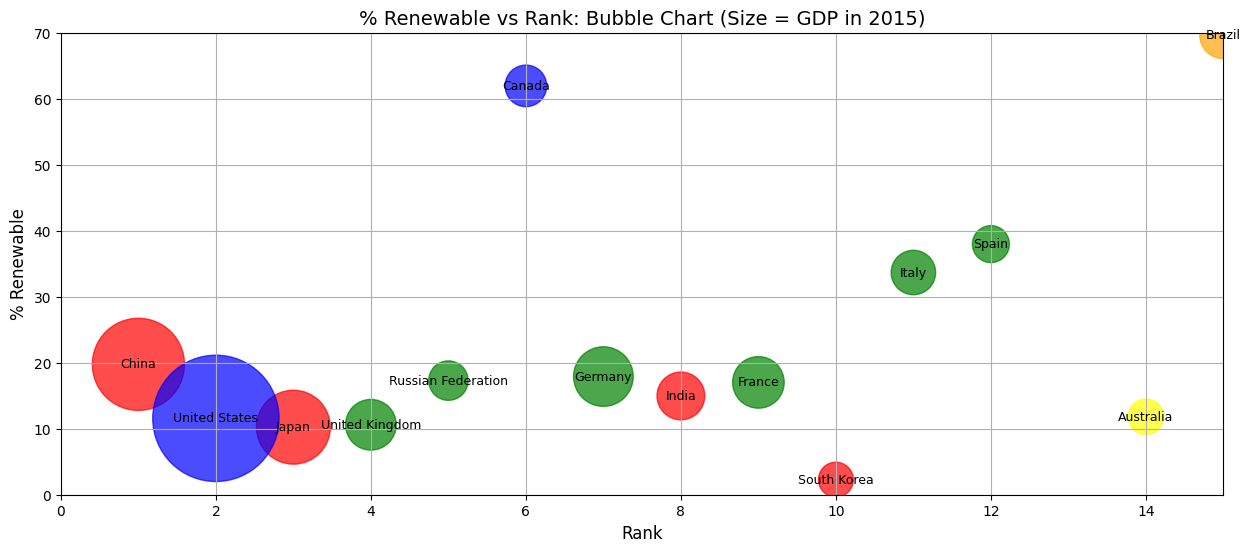

In [24]:
import matplotlib.pyplot as plt
import numpy as np

ContinentDict = {
    'China': 'Asia',
    'United States': 'North America',
    'Japan': 'Asia',
    'United Kingdom': 'Europe',
    'Russian Federation': 'Europe',
    'Canada': 'North America',
    'Germany': 'Europe',
    'India': 'Asia',
    'France': 'Europe',
    'South Korea': 'Asia',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'Iran': 'Asia',
    'Australia': 'Australia',
    'Brazil': 'South America'
}
final_merged_df['Continent'] = final_merged_df.index.map(ContinentDict)

df_bubble = final_merged_df[['Rank', '% Renewable', '2015', 'Continent']].dropna()

bubble_size = df_bubble['2015']

continent_colors = {
    'Asia': 'blue',
    'North America': 'blue',
    'Europe': 'green',
    'Australia': 'yellow',
    'South America': 'orange',
    'Asia': 'red'
}

bubble_colors = df_bubble['Continent'].map(continent_colors)

plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    df_bubble['Rank'],
    df_bubble['% Renewable'],
    s=bubble_size / 2e9,
    c=bubble_colors,
    alpha=0.7
)

# Додаємо назви країн в центр бульбашок
for i, country in enumerate(df_bubble.index):
    plt.text(
        df_bubble['Rank'].iloc[i], 
        df_bubble['% Renewable'].iloc[i], 
        country, 
        ha='center', 
        va='center', 
        color='black', 
        fontsize=9
    )

plt.xlim(0, 15)
plt.ylim(0, 70)

plt.title('% Renewable vs Rank: Bubble Chart (Size = GDP in 2015)', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('% Renewable', fontsize=12)

plt.grid(True)
plt.show()